In [30]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

In [31]:
n_per_cluster = 1_000
img_size = 91

x = np.linspace(-4, 4, img_size)
X, Y = np.meshgrid(x, x)

g_widths = [1.8, 2.4]

images = torch.zeros(2*n_per_cluster, 1, img_size, img_size)
labels = torch.zeros(2*n_per_cluster)

In [32]:
# for i in range(2*n_per_cluster):
#     random_offset = 2*np.random.randn(2)
#     gaussian = np.exp(-((X-random_offset[0])**2 + (Y-random_offset[1])**2) / (2*g_widths[i%2]**2))
#     # adding noise
#     gaussian = gaussian + np.random.randn(img_size, img_size) / 5
#     images[i,:,:,:] = torch.Tensor(gaussian).reshape(1, img_size, img_size)
#     labels[i] = i%2

# labels = labels[:, None]

In [33]:
import torchvision.transforms as T

In [34]:
for i in range(2*n_per_cluster):
    random_offset = 2*np.random.randn(2)
    gaussian = np.exp(-((X-random_offset[0])**2 + (Y-random_offset[1])**2) / (2*g_widths[i%2]**2))
    # adding noise
    gaussian = gaussian + np.random.randn(img_size, img_size) / 5
    ##gaussian = (gaussian - np.min(gaussian)) / (np.max(gaussian) - np.min(gaussian))
    images[i,:,:,:] = torch.Tensor(gaussian).reshape(1, img_size, img_size)
    labels[i] = i%2

labels = labels[:, None]

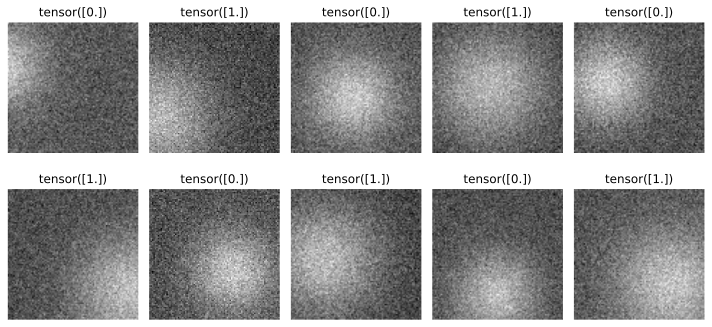

In [35]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i, :, :, :].view(img_size, img_size, 1), cmap="gray")
    ax.set_title(f"{labels[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [36]:
images[0]

tensor([[[ 1.0363,  0.0848,  0.3476,  ...,  0.4334, -0.2643,  0.0255],
         [ 0.2946,  0.0894,  0.1804,  ..., -0.0876,  0.0797,  0.3128],
         [ 0.0627,  0.4354, -0.2237,  ...,  0.0947,  0.4544,  0.1391],
         ...,
         [ 0.2902,  0.2555,  0.2999,  ..., -0.0595, -0.0448, -0.3732],
         [ 0.0922, -0.1490,  0.0293,  ...,  0.1882,  0.3559, -0.0159],
         [-0.2420,  0.0360,  0.4728,  ...,  0.1703, -0.0246, -0.1734]]])

In [37]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.2)
print(f"{train_data.shape=}, {train_labels.shape=}, {test_data.shape=}, {test_labels.shape=}")

train_data.shape=torch.Size([1600, 1, 91, 91]), train_labels.shape=torch.Size([1600, 1]), test_data.shape=torch.Size([400, 1, 91, 91]), test_labels.shape=torch.Size([400, 1])


In [38]:
train_ds = TensorDataset(train_data, train_labels)
test_ds = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [39]:
def create_model():
    class GauseNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 6, 5, 1, 2) # (91 - 5 + 4)/1 = 91
            self.pool1 = nn.MaxPool2d(2) # 91 // 2 = 45
            self.conv2 = nn.Conv2d(6, 4, 5, 1, 2) # (45 - 5 + 4)/1 = 45
            self.pool2 = nn.MaxPool2d(2) # 45 // 2 = 22
            expected_size = 4*(22**2)
            self.fc1 = nn.Linear(expected_size, 50)
            self.out = nn.Linear(50, 1)
        def forward(self, x):
            x = torch.relu(self.pool1(self.conv1(x)))
            x = torch.relu(self.pool2(self.conv2(x)))
            x = x.reshape(x.shape[0], -1)
            x = torch.relu(self.fc1(x))
            return self.out(x)
    net = GauseNet()
    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)
    return net, lossfunc, optimizer

In [40]:
net, lossfunc, _ = create_model()
tmp_out = net(torch.randn(5, 1, 91, 91))
print(tmp_out.shape)
loss = lossfunc(tmp_out, torch.zeros(5, 1))
loss

torch.Size([5, 1])


tensor(0.5975, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [41]:
def train_model():
    epoch = 100
    train_acc = []
    test_acc = []
    losses = []

    net, lossfunc, optimizer = create_model()

    for ei in range(epoch):
        batch_acc = []
        batch_loss = []
        net.train()
        for x, y in train_loader:
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            batch_loss.append(loss.item())
            acc = 100*torch.mean(((y_pred>0).float()==y).float()).item()
            batch_acc.append(acc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        net.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            y_test = net(x)
            test_acc.append(100*torch.mean(((y_test>0).float()==y).float()).item())
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))
        print(f"{ei=}, {losses[-1]=} {test_acc[-1]=}")
    
    return train_acc, test_acc, losses, net

In [42]:
train_acc, test_acc, losses, net = train_model()

ei=0, losses[-1]=0.5516399447619915 test_acc[-1]=88.49999904632568
ei=1, losses[-1]=0.2599203349277377 test_acc[-1]=90.24999737739563
ei=2, losses[-1]=0.1949285474792123 test_acc[-1]=93.25000047683716
ei=3, losses[-1]=0.1227126548346132 test_acc[-1]=94.74999904632568
ei=4, losses[-1]=0.15490825838409364 test_acc[-1]=89.99999761581421
ei=5, losses[-1]=0.14243832423817365 test_acc[-1]=93.99999976158142
ei=6, losses[-1]=0.08032006765250116 test_acc[-1]=93.99999976158142
ei=7, losses[-1]=0.09508167687337846 test_acc[-1]=95.99999785423279
ei=8, losses[-1]=0.05562770913820714 test_acc[-1]=94.74999904632568
ei=9, losses[-1]=0.06861551718786359 test_acc[-1]=95.74999809265137
ei=10, losses[-1]=0.05494719282651204 test_acc[-1]=94.49999928474426
ei=11, losses[-1]=0.060476037474290936 test_acc[-1]=97.00000286102295


KeyboardInterrupt: 

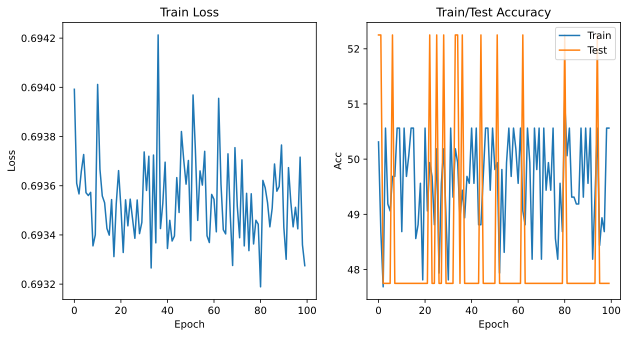

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(losses)
ax[0].set_title("Train Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(train_acc)
ax[1].plot(test_acc)
ax[1].set_title("Train/Test Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Acc")
ax[1].legend(["Train", "Test"])

plt.show()

In [13]:
def create_model():
    class GauseAvgNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, 1, 1),
                nn.AvgPool2d(2, 2),
                nn.ReLU(),
                nn.Conv2d(6, 4, 3, 1, 1),
                nn.AvgPool2d(2, 2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(4*22*22, 50),
                nn.ReLU(),
                nn.Linear(50, 1)
            )
        def forward(self, x):
            return self.enc(x)
            
    net = GauseAvgNet()
    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)
    return net, lossfunc, optimizer

In [14]:
def train_model():
    epoch = 30
    train_acc = []
    test_acc = []
    losses = []

    net, lossfunc, optimizer = create_model()

    for ei in range(epoch):
        batch_acc = []
        batch_loss = []
        net.train()
        for x, y in train_loader:
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            batch_loss.append(loss.item())
            acc = 100*torch.mean(((y_pred>0).float()==y).float()).item()
            batch_acc.append(acc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        net.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            y_test = net(x)
            test_acc.append(100*torch.mean(((y_test>0).float()==y).float()).item())
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))
        print(f"{ei=}, {losses[-1]=} {test_acc[-1]=}")
    
    return train_acc, test_acc, losses, net

In [15]:
train_acc, test_acc, losses, net = train_model()

ei=0, losses[-1]=0.44953027602285145 test_acc[-1]=94.24999952316284
ei=1, losses[-1]=0.1185367719316855 test_acc[-1]=97.00000286102295
ei=2, losses[-1]=0.06121380190423224 test_acc[-1]=99.00000095367432
ei=3, losses[-1]=0.1035523730062414 test_acc[-1]=99.00000095367432
ei=4, losses[-1]=0.036985175679874374 test_acc[-1]=99.25000071525574
ei=5, losses[-1]=0.06118053862708621 test_acc[-1]=99.50000047683716
ei=6, losses[-1]=0.015760275118300342 test_acc[-1]=98.7500011920929
ei=7, losses[-1]=0.029440649362409203 test_acc[-1]=96.74999713897705
ei=8, losses[-1]=0.12048673676268663 test_acc[-1]=99.25000071525574
ei=9, losses[-1]=0.007322439980304125 test_acc[-1]=100.0
ei=10, losses[-1]=0.010943011132124028 test_acc[-1]=97.00000286102295
ei=11, losses[-1]=0.03786524336104776 test_acc[-1]=100.0
ei=12, losses[-1]=0.002609015530453007 test_acc[-1]=100.0
ei=13, losses[-1]=0.006015736663820643 test_acc[-1]=99.75000023841858
ei=14, losses[-1]=0.051037377900789806 test_acc[-1]=96.74999713897705
ei=15,

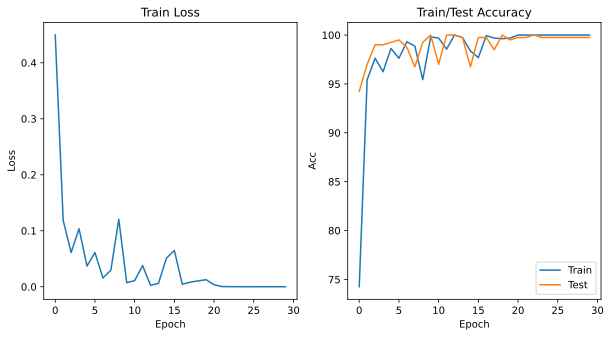

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(losses)
ax[0].set_title("Train Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(train_acc)
ax[1].plot(test_acc)
ax[1].set_title("Train/Test Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Acc")
ax[1].legend(["Train", "Test"])

plt.show()

In [17]:
summary(net, (1, 91, 91), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
         AvgPool2d-2            [-1, 6, 45, 45]               0
              ReLU-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
         AvgPool2d-5            [-1, 4, 22, 22]               0
              ReLU-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
              ReLU-9                   [-1, 50]               0
           Linear-10                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.67
Params size (MB): 0.37
Estimated Tot

In [66]:
print(
net.enc[0].weight.shape,
net.enc[3].weight.shape,
net.enc[7].weight.shape,
net.enc[9].weight.shape,
)

torch.Size([6, 1, 3, 3]) torch.Size([4, 6, 3, 3]) torch.Size([50, 1936]) torch.Size([1, 50])


## Draw out the Feature Maps

In [19]:
## imshow feature maps generated before linear layer for deeper analysis.
## Do PCA or coeffcorrelation after flatten to figure out if you need more channels or less based on how many channels are getting activated to generate output tensor

## Run parametric experiment on GPU

In [43]:
def create_model(hidden_x: int):
    class GauseAvgNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.hidden_x = hidden_x
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, 1, 1),
                nn.ReLU(),
                nn.AvgPool2d(2, 2),
                nn.Conv2d(6, 4, 3, 1, 1),
                nn.ReLU(),
                nn.AvgPool2d(2, 2),
                nn.Flatten(),
                nn.Linear(4*22*22, 2*self.hidden_x),
                nn.ReLU(),
                nn.Linear(2*self.hidden_x, self.hidden_x),
                nn.ReLU(),
                nn.Linear(self.hidden_x, 1)
            )
        def forward(self, x):
            return self.enc(x)
            
    net = GauseAvgNet()
    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)
    return net, lossfunc, optimizer

In [44]:
hidden_xs = np.linspace(5, 500, 21, dtype=int)
hidden_xs

array([  5,  29,  54,  79, 104, 128, 153, 178, 203, 227, 252, 277, 302,
       326, 351, 376, 401, 425, 450, 475, 500])

In [45]:
def train_model(hidden_x):
    epoch = 20
    train_acc = []
    test_acc = []
    losses = []

    net, lossfunc, optimizer = create_model(hidden_x)
    net.to(device="cuda:0")

    for ei in range(epoch):
        batch_acc = []
        batch_loss = []
        net.train()
        for x, y in train_loader:
            x = x.to(device="cuda:0")
            y = y.to(device="cuda:0")
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            batch_loss.append(loss.item())
            acc = 100*torch.mean(((y_pred>0).float()==y).float()).item()
            batch_acc.append(acc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        net.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            x = x.to(device="cuda:0")
            y = y.to(device="cuda:0")
            y_test = net(x)
            test_acc.append(100*torch.mean(((y_test>0).float()==y).float()).item())
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))
        print(f"{ei=}, {losses[-1]=} {test_acc[-1]=}")
    
    return train_acc, test_acc, losses, net

In [46]:
results = np.zeros((len(hidden_xs), 2))
for i, hidden_x in enumerate(hidden_xs):
    train_acc, test_acc, losses, net = train_model(hidden_x)
    results[i, 0] = losses[-1]
    results[i, 1] = test_acc[-1]
    print(f"Running {hidden_x=}: Loss={losses[-1]} Test_Acc={test_acc[-1]}")

ei=0, losses[-1]=0.6996563827991485 test_acc[-1]=47.999998927116394
ei=1, losses[-1]=0.6936939203739166 test_acc[-1]=47.999998927116394
ei=2, losses[-1]=0.6933261102437973 test_acc[-1]=47.999998927116394
ei=3, losses[-1]=0.6933263498544693 test_acc[-1]=47.999998927116394
ei=4, losses[-1]=0.6933607441186905 test_acc[-1]=47.999998927116394
ei=5, losses[-1]=0.693575182557106 test_acc[-1]=47.999998927116394
ei=6, losses[-1]=0.6934680444002151 test_acc[-1]=47.999998927116394
ei=7, losses[-1]=0.6936187475919724 test_acc[-1]=47.999998927116394
ei=8, losses[-1]=0.6932507103681564 test_acc[-1]=47.999998927116394
ei=9, losses[-1]=0.6937215912342072 test_acc[-1]=47.999998927116394
ei=10, losses[-1]=0.6934666538238525 test_acc[-1]=47.999998927116394
ei=11, losses[-1]=0.6935366028547287 test_acc[-1]=47.999998927116394
ei=12, losses[-1]=0.6933281922340393 test_acc[-1]=47.999998927116394
ei=13, losses[-1]=0.6936056226491928 test_acc[-1]=47.999998927116394
ei=14, losses[-1]=0.6933731240034103 test_acc

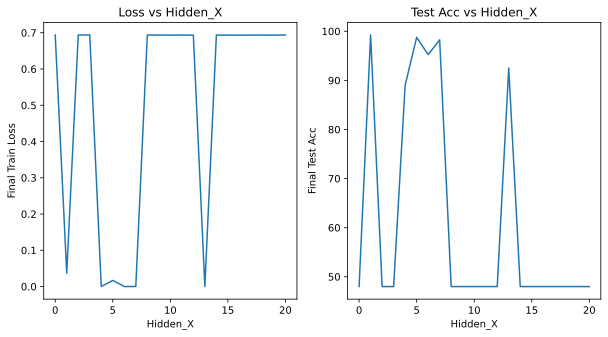

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(results[:,0])
ax[0].set_title("Loss vs Hidden_X")
ax[0].set_xlabel("Hidden_X")
ax[0].set_ylabel("Final Train Loss")

ax[1].plot(results[:,1])
ax[1].set_title("Test Acc vs Hidden_X")
ax[1].set_xlabel("Hidden_X")
ax[1].set_ylabel("Final Test Acc")

plt.show()